2024-12-06 16:10:24.562302: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 16:10:24.565014: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 16:10:24.597325: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 16:10:24.597343: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 16:10:24.597363: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Epoch 1/5, Loss: 2.6692, Accuracy: 24.91%, Val Accuracy: 37.65%
Epoch 2/5, Loss: 2.1999, Accuracy: 36.17%, Val Accuracy: 37.89%
Epoch 3/5, Loss: 1.8418, Accuracy: 45.28%, Val Accuracy: 37.45%
Epoch 4/5, Loss: 1.4761, Accuracy: 55.23%, Val Accuracy: 36.02%
Epoch 5/5, Loss: 1.1526, Accuracy: 64.34%, Val Accuracy: 35.38%


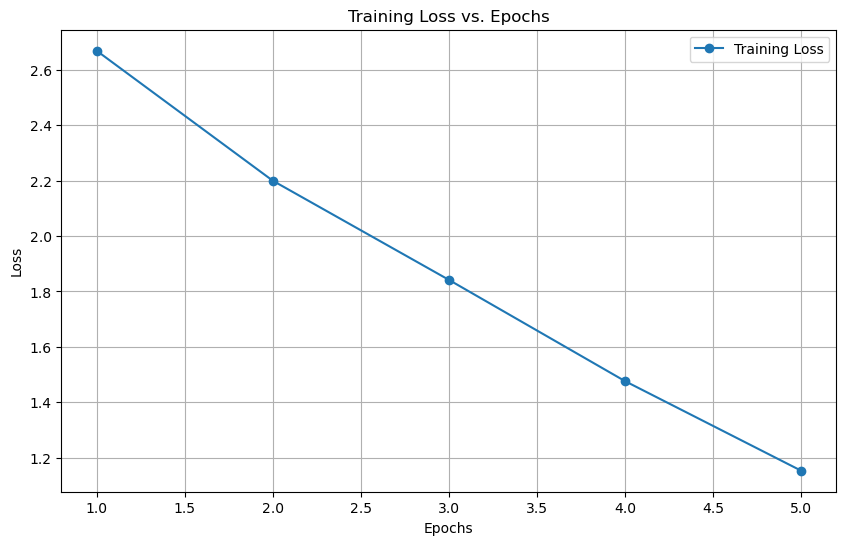

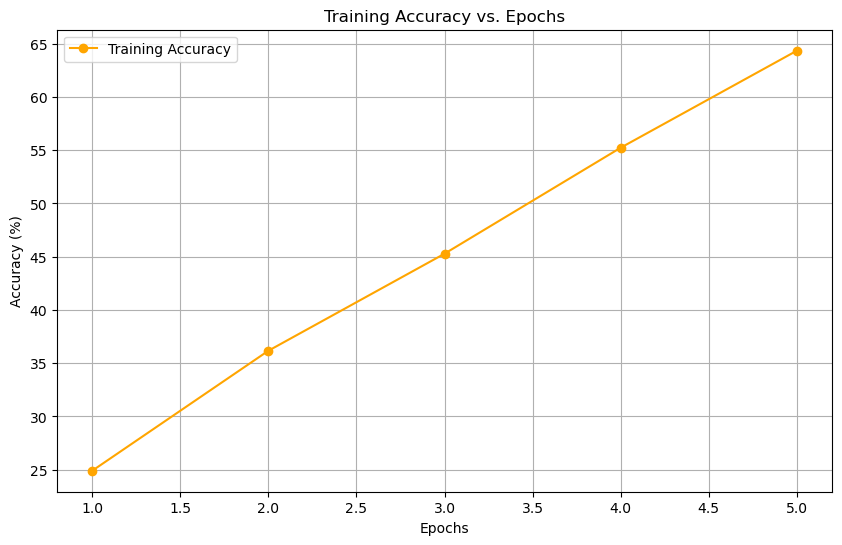

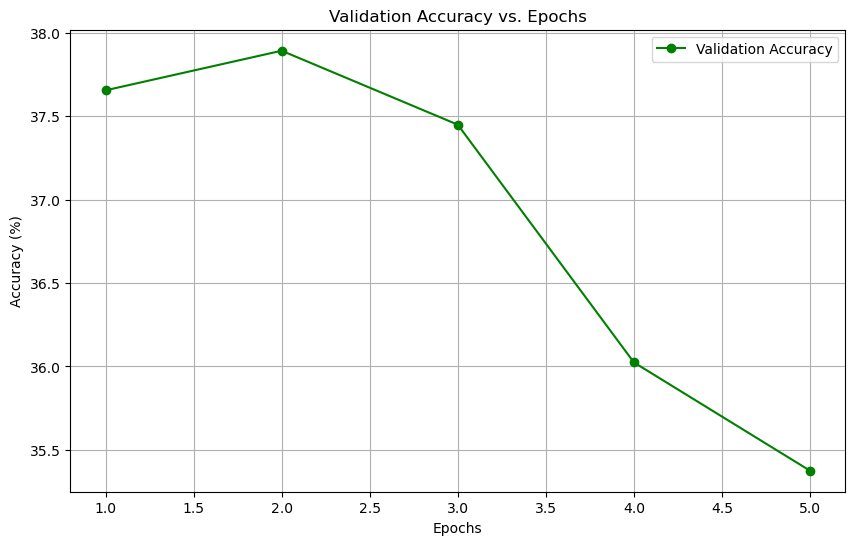

Test Accuracy: 34.42%
Test Precision: 0.3499
Test Recall: 0.3442
Test F1 Score: 0.3427
Test Error Rate (Mean Absolute Error): 6.9754
Sample 1:
Text: I am so excited for my baby son to be born_comma_ I am so eager for it to happen!
Actual Context: anticipating
Predicted Context: anticipating

Sample 2:
Text: This morning my husband received a call_comma_ he got nervous_comma_ I think it was a woman ... difficult
Actual Context: jealous
Predicted Context: caring

Sample 3:
Text: The last time I went to the fair_comma_ I tripped and fell. There were so many people around that saw me hit the ground. You can imagine how I felt!
Actual Context: embarrassed
Predicted Context: embarrassed



In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support, mean_absolute_error
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch
import numpy as np

# Step 1: Load the datasets
train_df = pd.read_csv('updated_empathetic_dialogues_train.csv', on_bad_lines='skip')
val_df = pd.read_csv('updated_empathetic_dialogues_val.csv', on_bad_lines='skip')
test_df = pd.read_csv('updated_empathetic_dialogues_test.csv', on_bad_lines='skip')

# Step 2: Label Encode the 'context' column
label_encoder = LabelEncoder()
train_df['context_encoded'] = label_encoder.fit_transform(train_df['context'])
val_df['context_encoded'] = label_encoder.transform(val_df['context'])
test_df['context_encoded'] = label_encoder.transform(test_df['context'])

# Step 3: Prepare the data
train_texts = train_df['utterance'].tolist()
train_labels = train_df['context_encoded'].tolist()
val_texts = val_df['utterance'].tolist()
val_labels = val_df['context_encoded'].tolist()
test_texts = test_df['utterance'].tolist()
test_labels = test_df['context_encoded'].tolist()

# Step 4: Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
test_encodings = tokenize_function(test_texts)

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_labels))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(test_labels))

# Step 5: Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# Step 6: Model Initialization
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Step 7: Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 5
training_losses = []
training_accuracies = []
validation_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_dataloader)
    accuracy = correct_preds / total_preds * 100
    training_losses.append(avg_loss)
    training_accuracies.append(accuracy)

    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)
    val_accuracy = correct_preds / total_preds * 100
    validation_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

# Step 8: Graphs

# 1. Training Loss vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, marker='o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.grid()
plt.show()

# 2. Training Accuracy vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_accuracies, marker='o', label='Training Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy vs. Epochs')
plt.legend()
plt.grid()
plt.show()

# 3. Validation Accuracy vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), validation_accuracies, marker='o', label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy vs. Epochs')
plt.legend()
plt.grid()
plt.show()

# Step 9: Evaluate Test Dataset
true_test_labels = []
test_predictions = []
correct_test_preds = 0
total_test_preds = 0

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        true_test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(preds.cpu().numpy())
        correct_test_preds += torch.sum(preds == labels).item()
        total_test_preds += labels.size(0)

# Compute Test Metrics
test_accuracy = correct_test_preds / total_test_preds * 100
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(true_test_labels, test_predictions, average='weighted')
test_error_rate = mean_absolute_error(true_test_labels, test_predictions)

# Print Test Metrics
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Error Rate (Mean Absolute Error): {test_error_rate:.4f}")

sample_cases = test_df.sample(3)
sample_texts = sample_cases['utterance'].tolist()
sample_labels = sample_cases['context'].tolist()
encoded_samples = tokenize_function(sample_texts)

model.eval()
with torch.no_grad():
    sample_input_ids = encoded_samples['input_ids'].to(device)
    sample_attention_mask = encoded_samples['attention_mask'].to(device)
    outputs = model(input_ids=sample_input_ids, attention_mask=sample_attention_mask)
    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

predicted_labels = label_encoder.inverse_transform(predictions)

for i, (text, actual, predicted) in enumerate(zip(sample_texts, sample_labels, predicted_labels)):
    print(f"Sample {i+1}:")
    print(f"Text: {text}")
    print(f"Actual Context: {actual}")
    print(f"Predicted Context: {predicted}")
    print()
